# Elastica basics
This notebook serves as a basic explanation of elastica, implementing both a numnerical estimation of the elastica energy, and a derived one (Sharon et al). This is for the Keemink and van Rossum 2015 paper. 

For the underlying code see elastica.py 

Necessary libraries:
- matplotlib
- scipy
- numpy
- HoloViews (http://holoviews.org/)

TODO:
- add derived vs actual elastica energy

Let's start with the imports.

In [1]:
import holoviews as hv
%load_ext holoviews.ipython
%output widgets='embed' holomap='widgets' size=150 fig='png'
import elastica as el
import pylab    as pl

In Sharon et al's integration method, elastica is defined to be scale independent. Therefore the curve length can safely assumed to be one. Given a curve $\psi(s)$ with start and end orientations $\psi_1$ and $\psi_2$ (where $s$ is the position along the curve) we would like to minimize it's curvature energy. This minimization problem takes the form
$$ min_\hat{\psi} \int_0^1 \hat{\psi}(s)^2 ds, \texttt{s.t} \int_0^1 \sin(\psi(s)) ds = 0, \hat{\psi}(0) = \psi_1, \hat{\psi}(1) = \psi_2  $$
Now through the Euler-Lagrange equations $\hat{\psi}$ should satisfy 
$$ 2\hat{\psi}'' = \lambda \cos \hat{\psi}  $$

 The function of the curvature $\psi$ as a function of position along the curve $s$ can be assumed to be approximated by:
$$ \psi(s) =  (1-s)\psi_1 + s\psi_2 + s(1-s)\sum_{k=0}^na_ks^k$$

The minimization with the python fsolve function. The functions relevant to this minimization are found in elastica.py. For more details of the derivation and minimization see Sharon et al (????).

Let's define some basic things for the integration method

In [2]:
# set parameters for single estimation
n = 10 # number of variables in polynomial (n+1) (higher will improve the polynomial estimate of the elastica curve)
nn = 100 # number of points to use for integration  (will improve the estimation of the curve integration)

Now, let's test an example situation and plot a curve for a given start and end orientation.

:Overlay
   .Curve.I   :Curve   [x]   (y)
   .Curve.II  :Curve   [x]   (y)
   .Curve.III :Curve   [x]   (y)
   .Curve.IV  :Curve   [x]   (y)
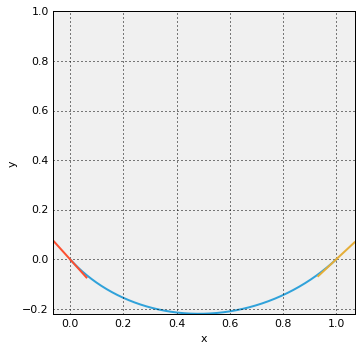

In [3]:
import warnings
warnings.filterwarnings('ignore')
# start and end orientations (keep between -pi and pi)
psi1 = 130*pl.pi/180
psi2 = -135*pl.pi/180
# Find the elastica curve in x and y coordinates
s,psi,E_best = el.findcurve(psi1,psi2,n=n,nn_fit=nn*1,nn_out=1000)
x = pl.cumsum(pl.cos(psi))*s[1]
y = pl.cumsum(pl.sin(psi))*s[1]
reload(el)
# Plot normalized so that the total displacement in the x direction is 1, with the relevant bars
hv.Curve(zip(x/abs(x[-1]),y/(x[-1])))*el.plotbar(0,0,-psi1+pl.pi/2,l=0.2)*el.plotbar(1,0,-psi2+pl.pi/2,l=0.2)*hv.Curve(zip([1],[1]))


Make the same as above, but as an widget

:HoloMap   [psi1,psi2]
   :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
      .Curve.IV  :Curve   [x]   (y)
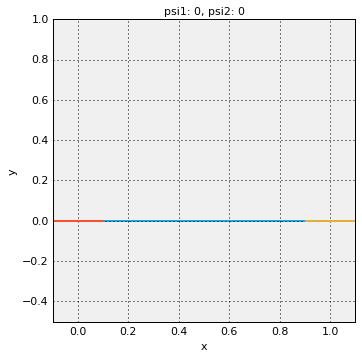
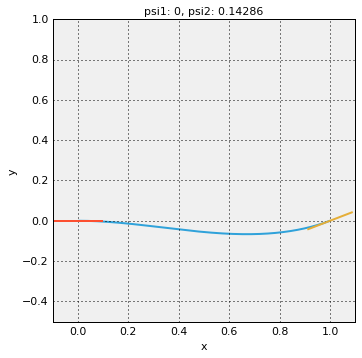
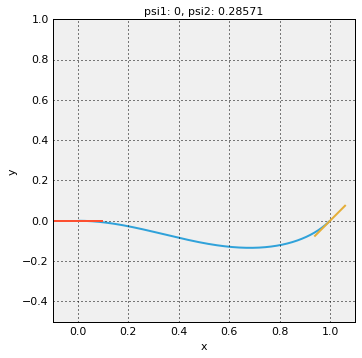
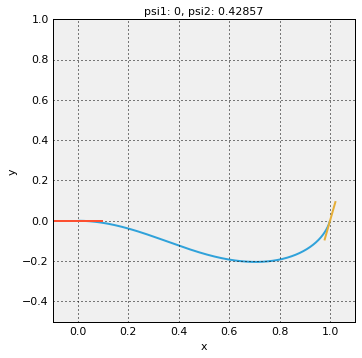
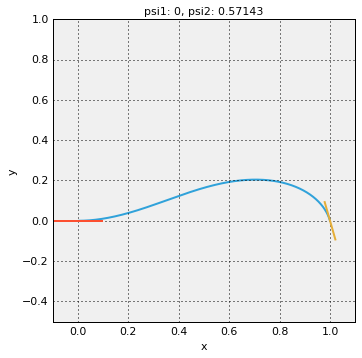
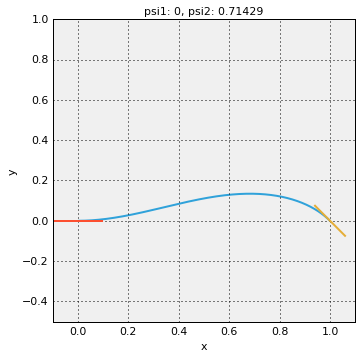
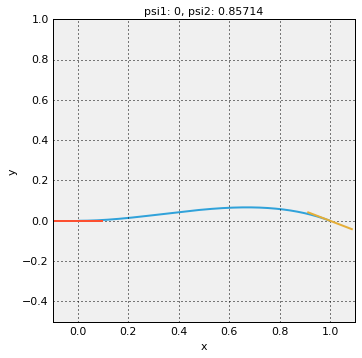
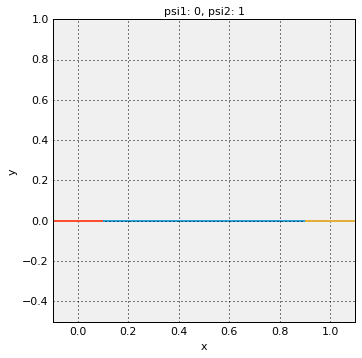
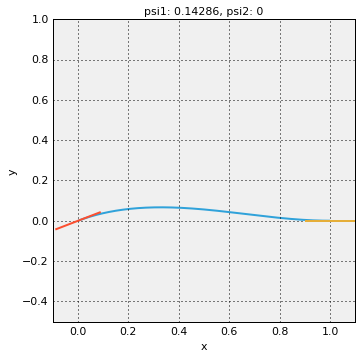
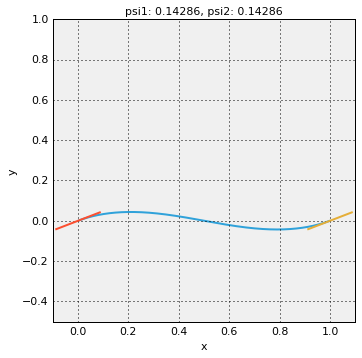
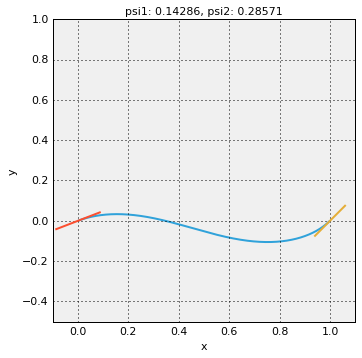
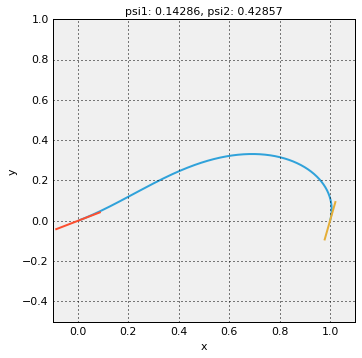
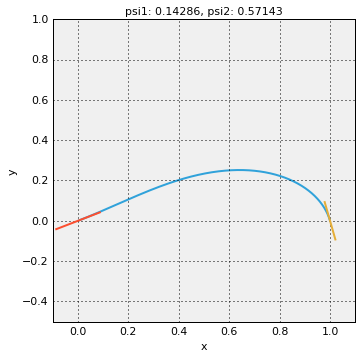
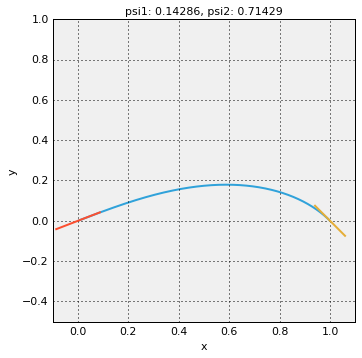
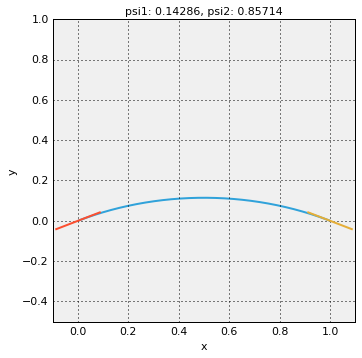
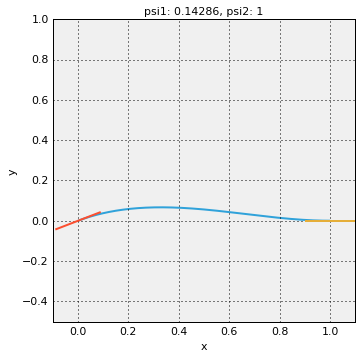
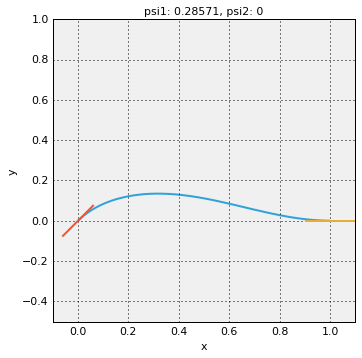
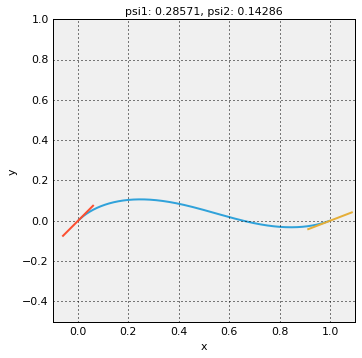
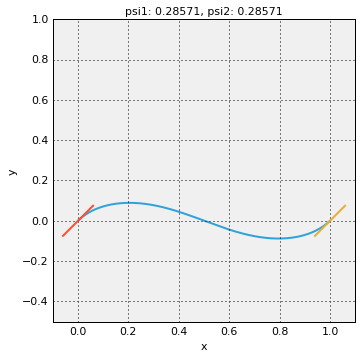
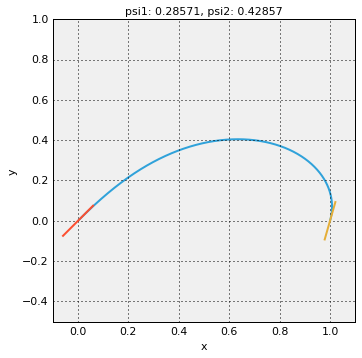
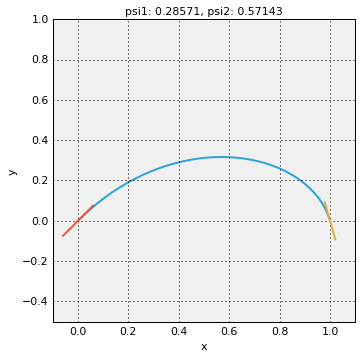
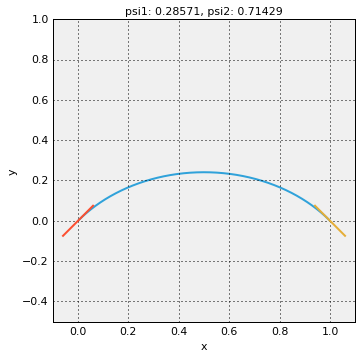
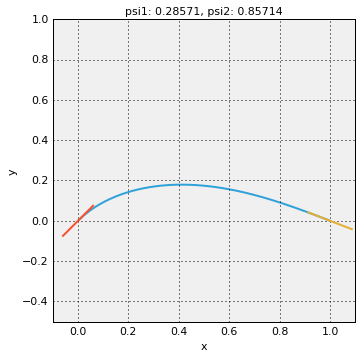
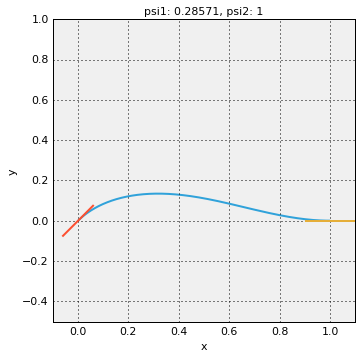
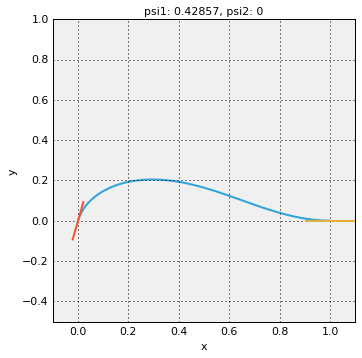
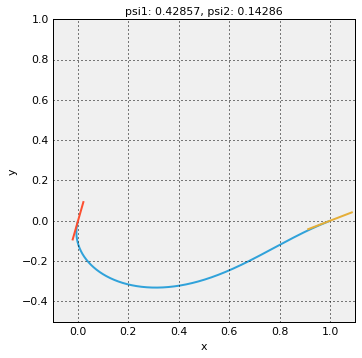
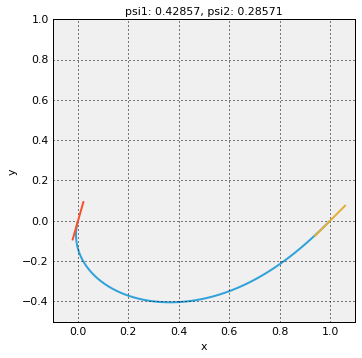
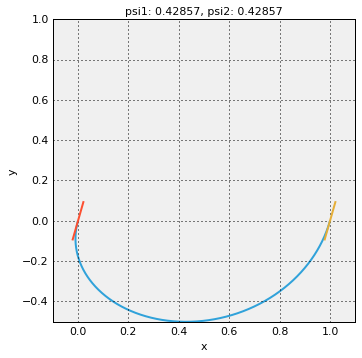
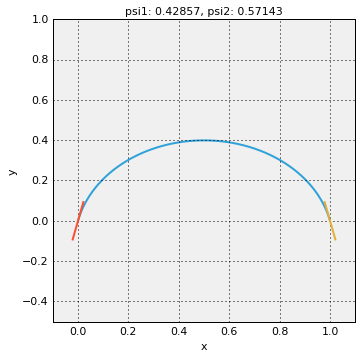
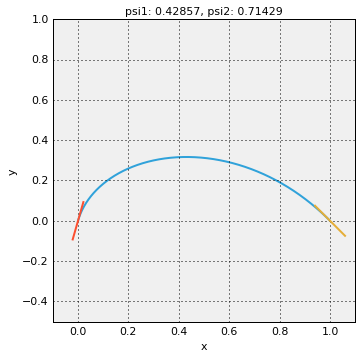
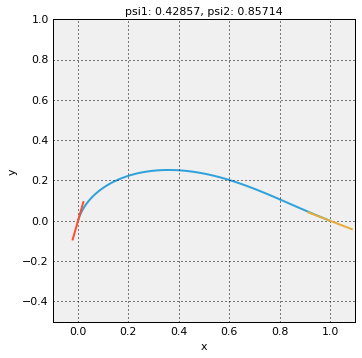
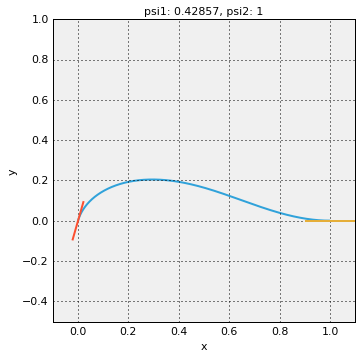
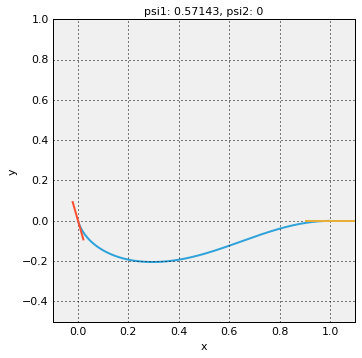
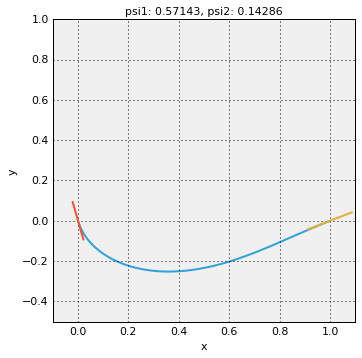
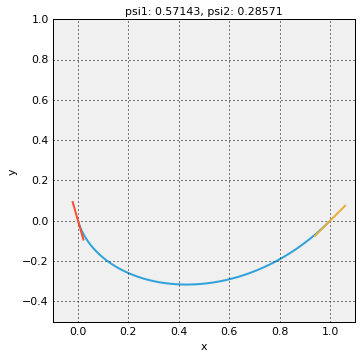
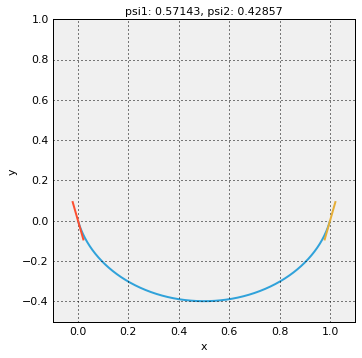
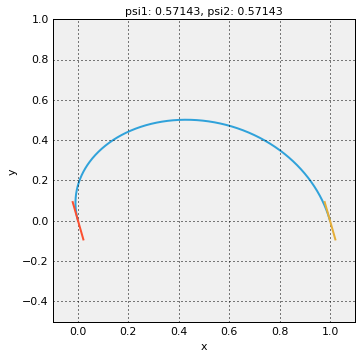
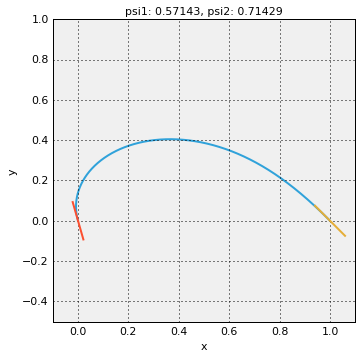
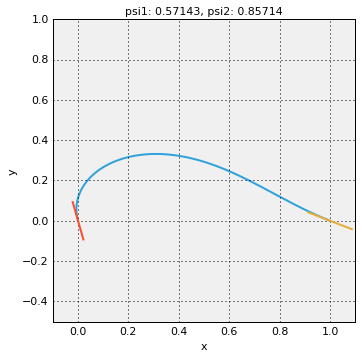
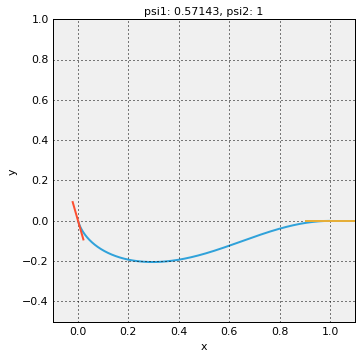
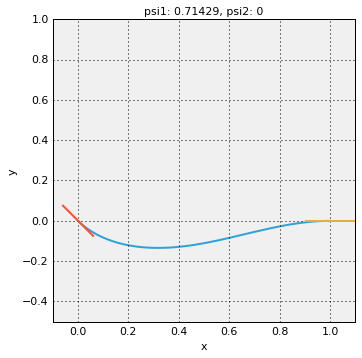
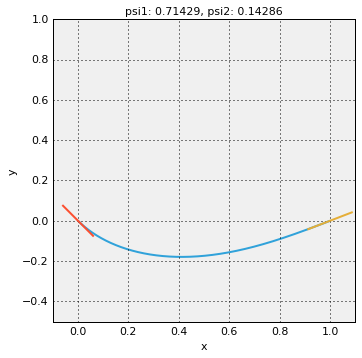
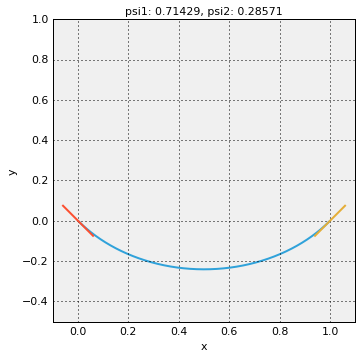
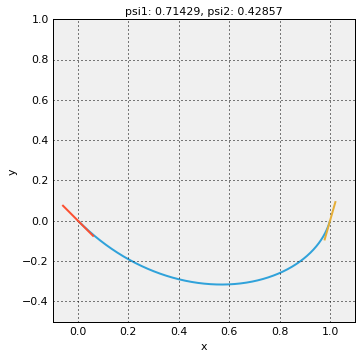
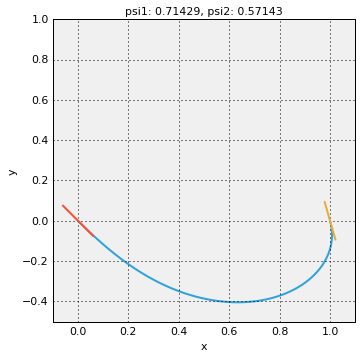
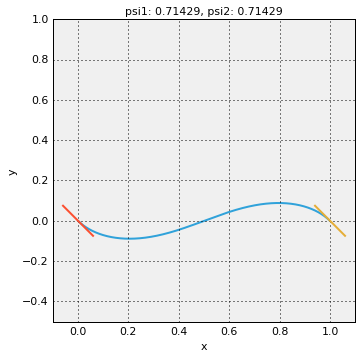
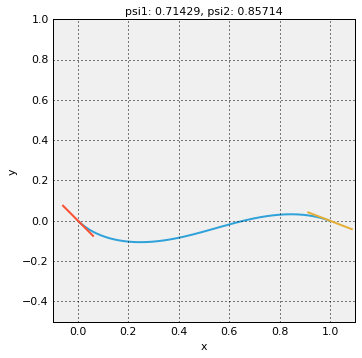
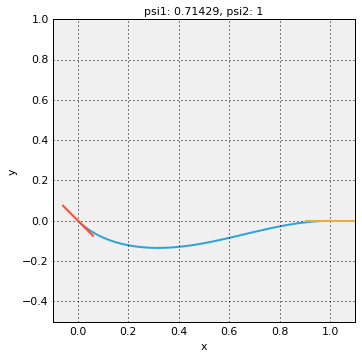
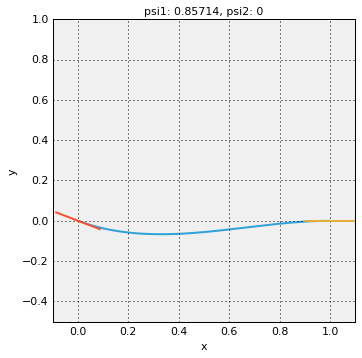
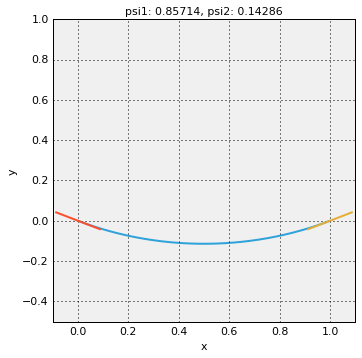
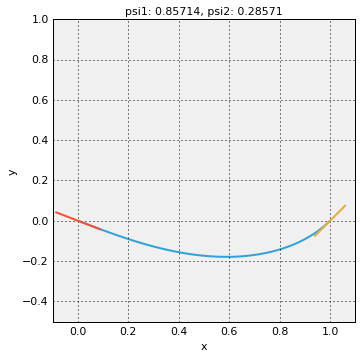
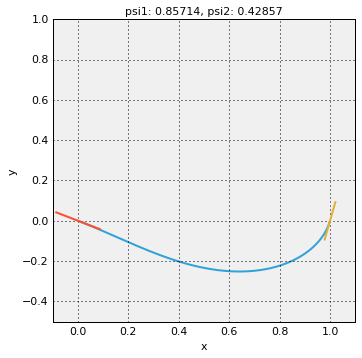
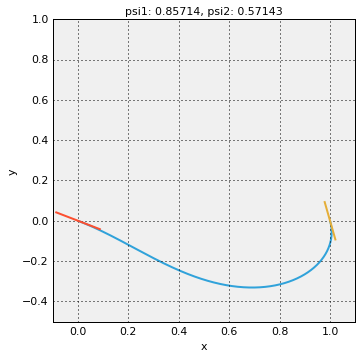
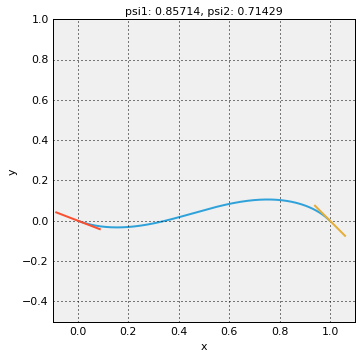
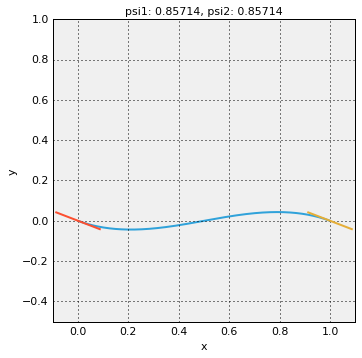
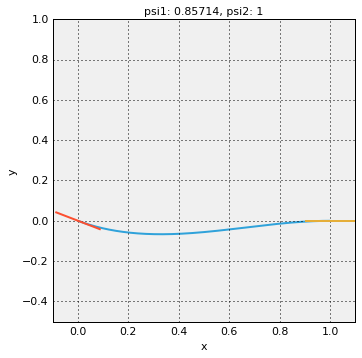
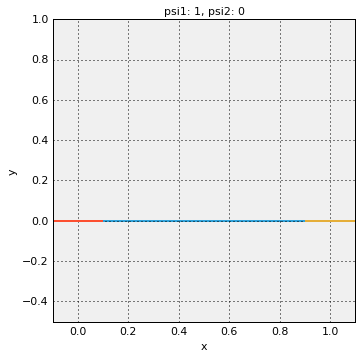
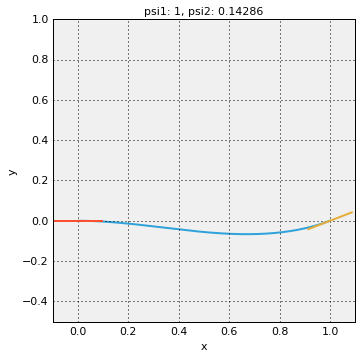
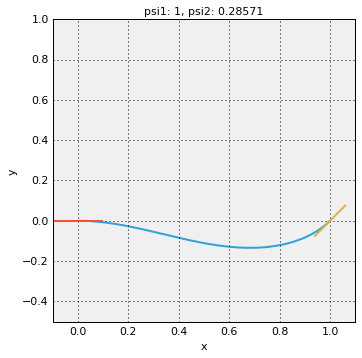
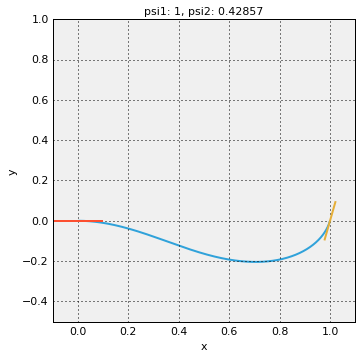
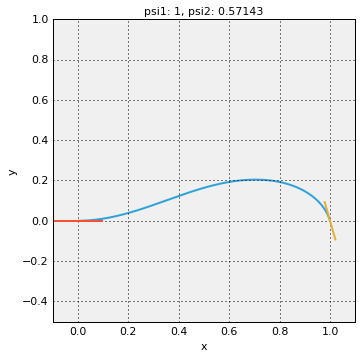
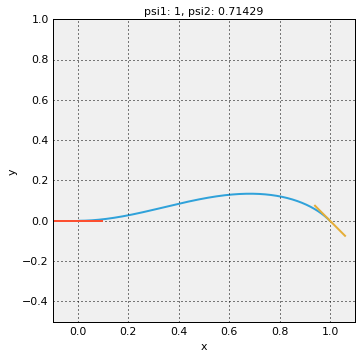
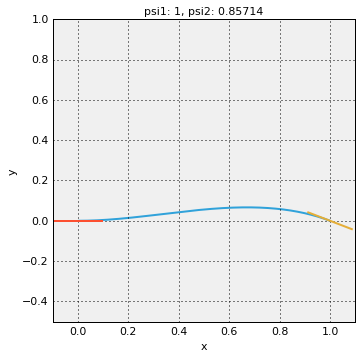
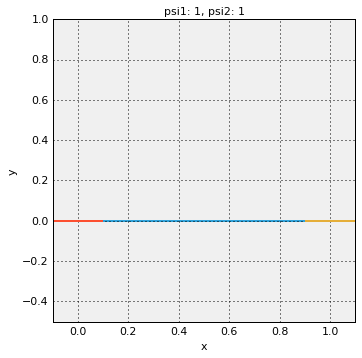

In [4]:
# define holomaps widget stuff
nPsi = 8                                       # number of different angles to use
PSIs = pl.linspace(0,1,nPsi)               # different angles
dimensions = ['psi1','psi2']                     # key dimentions
keys = [(psi1,psi2) for psi1 in PSIs for psi2 in PSIs]    # keys
items1 = ['']*nPsi*nPsi
items2 = ['']*nPsi*nPsi

# predfine widget
bars1 = hv.HoloMap(key_dimensions = dimensions)
bars2 = hv.HoloMap(key_dimensions = dimensions)
curves = hv.HoloMap(key_dimensions = dimensions)

# generate curves and bars for all keys
for i,key in enumerate(keys):
    # find angles
    psi1,psi2 = key
    psi1*=pl.pi
    psi2*=pl.pi
    # find curves
    s,psi,Ebest = el.findcurve(psi1,psi2,n=n,nn_fit=nn*1,nn_out=1000)
    x = pl.cumsum(pl.cos(psi))*s[1]
    y = pl.cumsum(pl.sin(psi))*s[1]
    
    # update holmap with bars and curve
    bars1[key] = el.plotbar(0,0,-psi1+pl.pi/2,l=0.2)
    bars2[key] = el.plotbar(1,0,-psi2+pl.pi/2,l=0.2)
    curves[key] = hv.Curve(zip(x/abs(x[-1]),y/(x[-1])))
    
    
    

# # curves = hv.HoloMap(items,key_dimensions = dimensions) # predefinition of curves
# bar1s = hv.HoloMap(items1,key_dimensions = dimensions) # predefinition of bar 1
# bar2s = hv.HoloMap(items2,key_dimensions = dimensions) # predefinition of bar 2
curves*bars1*bars2*hv.Curve(zip([1],[1]))

Note how since we use the direction independent elastica energy, the curve sometimes suddendly switches sides, as it becomes more efficient to be on the other side. 

We can also do the same but plot all curves from the second bar at once, and show their true energy profile, together the estimated energy profile following the sharon derivation.

In [5]:
# define holomaps widget stuff
nPsi = 16                                     # number of different angles to use
PSIs = pl.linspace(0,1,nPsi)               # different angles
dimensions = ['psi1']                     # key dimentions
keys = [(psi1) for psi1 in PSIs]    # keys
items = ['']*nPsi

# predfine widget
true_energies = hv.HoloMap(key_dimensions = dimensions)
derived_energies = hv.HoloMap(key_dimensions = dimensions)
curves = hv.HoloMap(key_dimensions = dimensions)

# generate curves and bars for all keys
for i,key in enumerate(keys):
    # find angles
    psi1 = key
    psi1*=pl.pi
    
    # initiate energy array
    E_true = pl.zeros(len(PSIs))
    E_der  = pl.zeros(len(PSIs))
    
    # do initial image
    psi2 = PSIs[0]
    psi2*= pl.pi
    
    # find curves
    s,psi,E_true[0] = el.findcurve(psi1,psi2,n=n,nn_fit=nn*1,nn_out=1000)
    x = pl.cumsum(pl.cos(psi))*s[1]
    y = pl.cumsum(pl.sin(psi))*s[1]
    
    # start basic curve
    img = hv.Curve(zip(x/abs(x[-1]),y/(x[-1])))
    
    # and for all other orientations
    for i,psi2 in enumerate(PSIs[1:]):
        psi2*=pl.pi
        
        # find curves
        s,psi,E_true[i+1] = el.findcurve(psi1,psi2,n=n,nn_fit=nn*1,nn_out=1000)
        x = pl.cumsum(pl.cos(psi))*s[1]
        y = pl.cumsum(pl.sin(psi))*s[1]
        
        # update the curve
        img *= hv.Curve(zip(x/abs(x[-1]),y/(x[-1])))
    
    # find the derived sharon energy, direction independent
    X = [0,3]
    d = pl.zeros((nPsi,4))
    d[:,0] = el.D(psi1,PSIs*pl.pi,X)
    d[:,1] = el.D(psi1+pl.pi,PSIs*pl.pi,X)
    d[:,2] = el.D(psi1+pl.pi,PSIs*pl.pi+pl.pi,X)
    d[:,3] = el.D(psi1,PSIs*pl.pi+pl.pi,X)
    
    # update holmap with bars and curve
    curves[key] = img
    true_energies[key] = hv.Curve(zip(PSIs,E_true))
    derived_energies[key] = hv.Curve(zip(PSIs,d.min(1)))
    

# # curves = hv.HoloMap(items,key_dimensions = dimensions) # predefinition of curves
# bar1s = hv.HoloMap(items1,key_dimensions = dimensions) # predefinition of bar 1
# bar2s = hv.HoloMap(items2,key_dimensions = dimensions) # predefinition of bar 2
# curves*bars1*bars2*hv.Curve(zip([1],[1]))

:Layout
   .HoloMap.I  :HoloMap   [psi1]
      :Overlay
         .Curve.I    :Curve   [x]   (y)
         .Curve.II   :Curve   [x]   (y)
         .Curve.III  :Curve   [x]   (y)
         .Curve.IV   :Curve   [x]   (y)
         .Curve.V    :Curve   [x]   (y)
         .Curve.VI   :Curve   [x]   (y)
         .Curve.VII  :Curve   [x]   (y)
         .Curve.VIII :Curve   [x]   (y)
         .Curve.IX   :Curve   [x]   (y)
         .Curve.X    :Curve   [x]   (y)
         .Curve.XI   :Curve   [x]   (y)
         .Curve.XII  :Curve   [x]   (y)
         .Curve.XIII :Curve   [x]   (y)
         .Curve.XIV  :Curve   [x]   (y)
         .Curve.XV   :Curve   [x]   (y)
         .Curve.XVI  :Curve   [x]   (y)
   .HoloMap.II :HoloMap   [psi1]
      :Overlay
         .Curve.I  :Curve   [x]   (y)
         .Curve.II :Curve   [x]   (y)
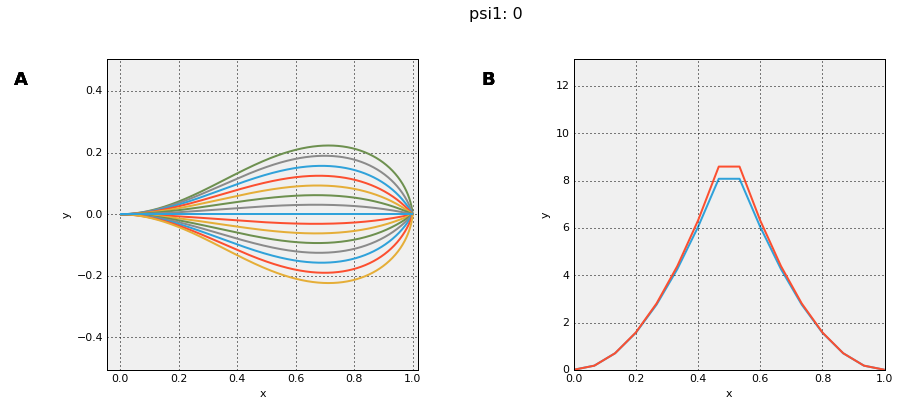
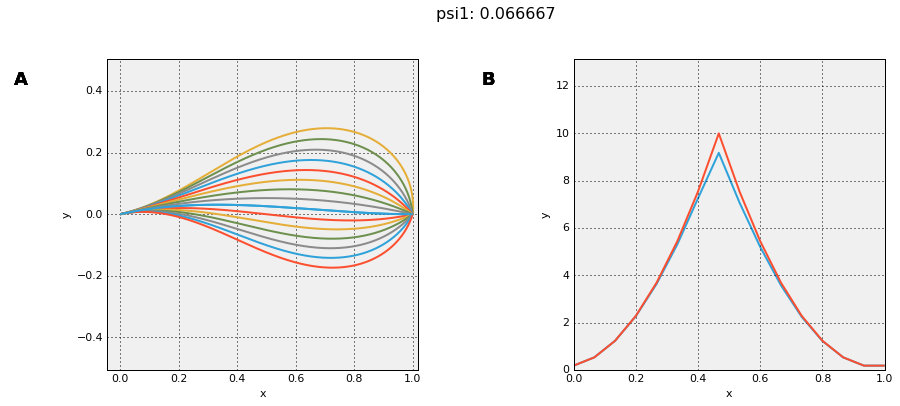
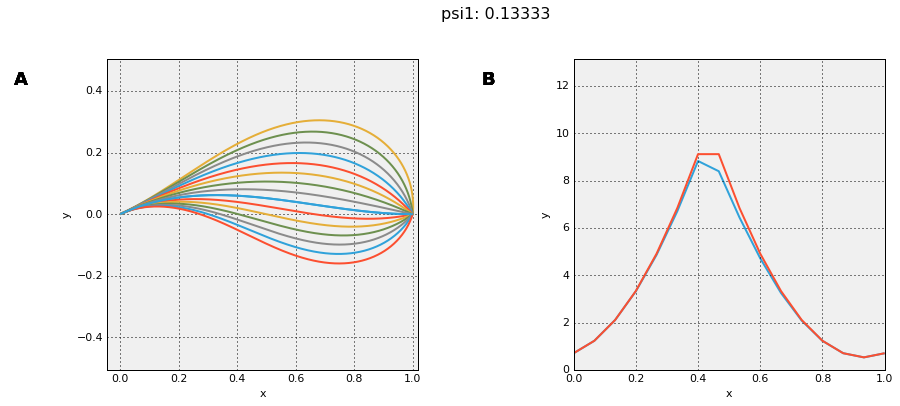
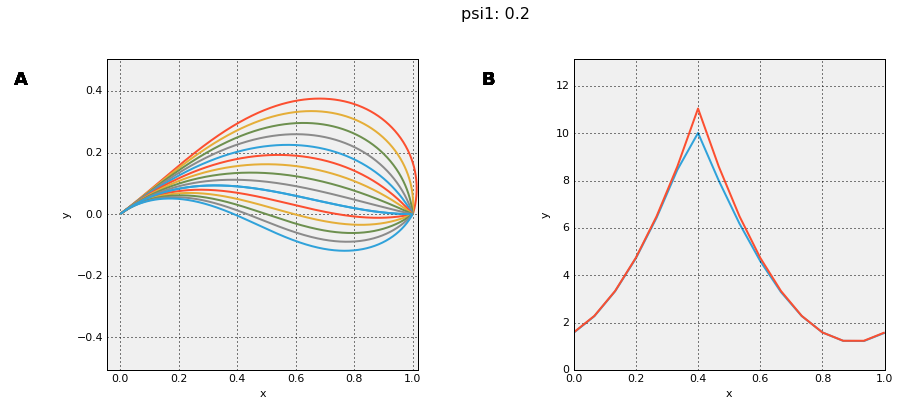
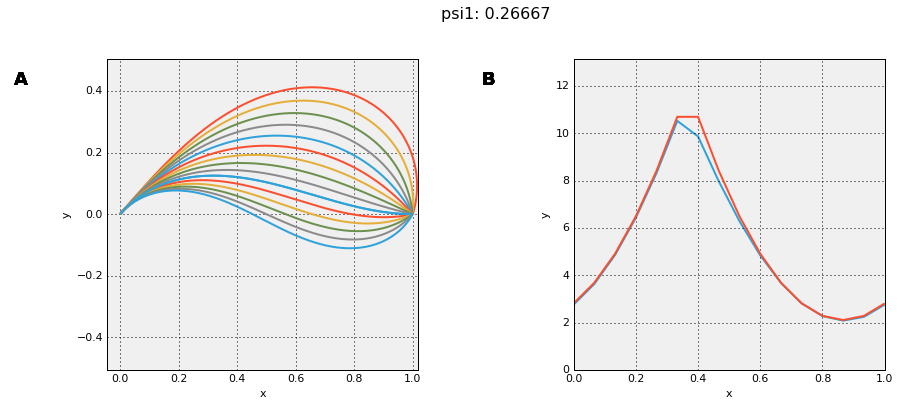
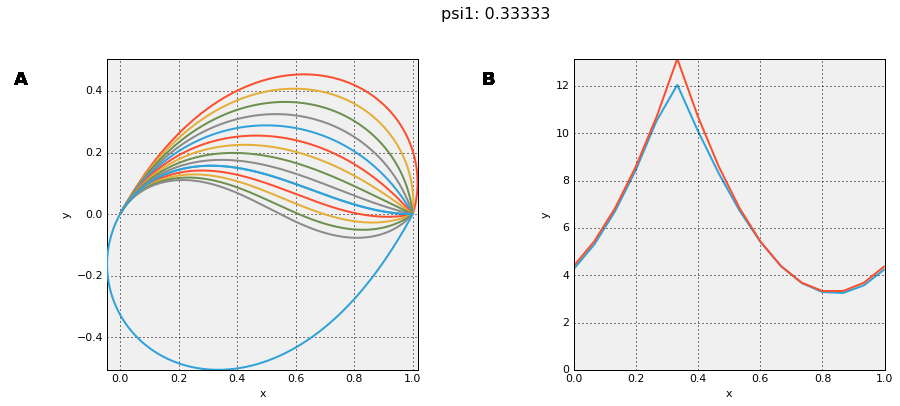
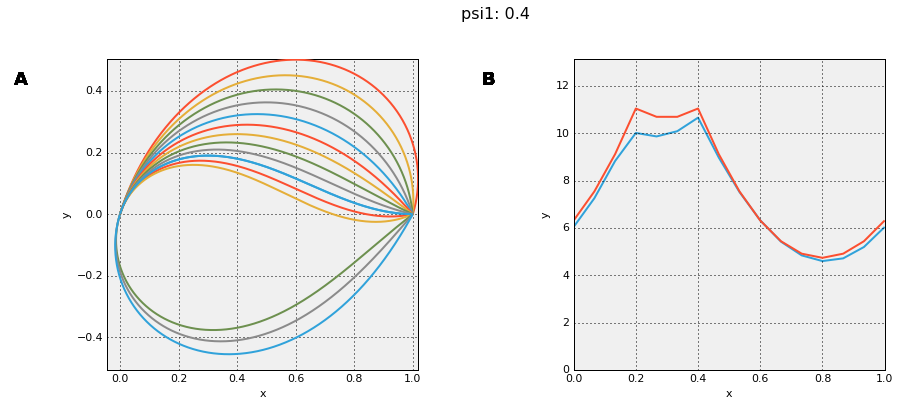
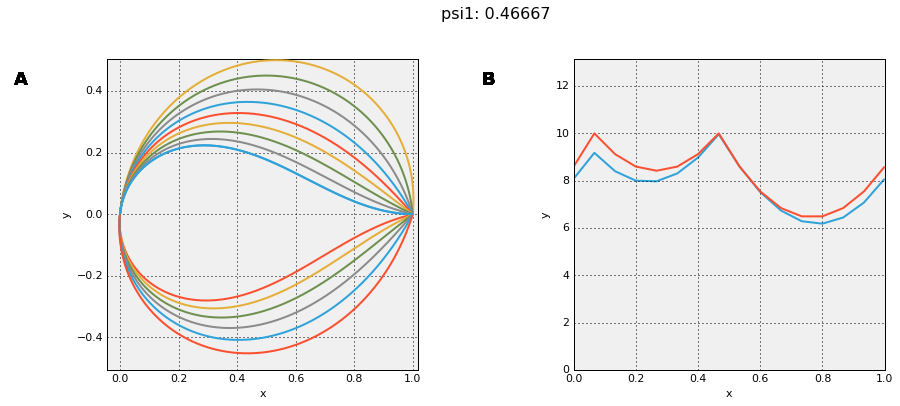
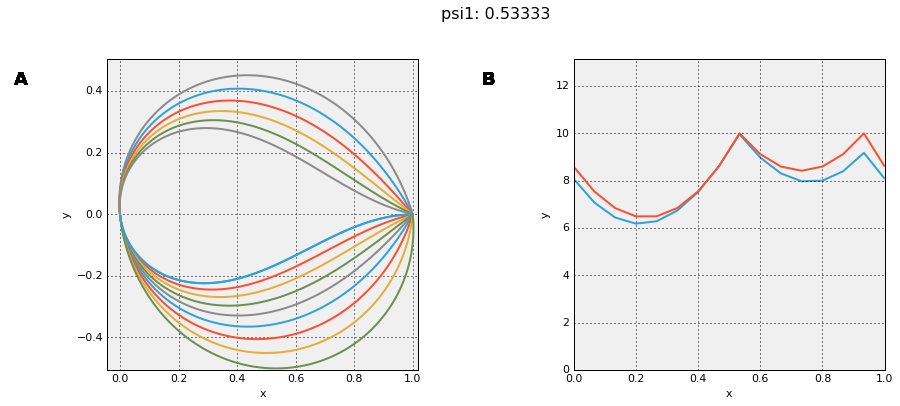
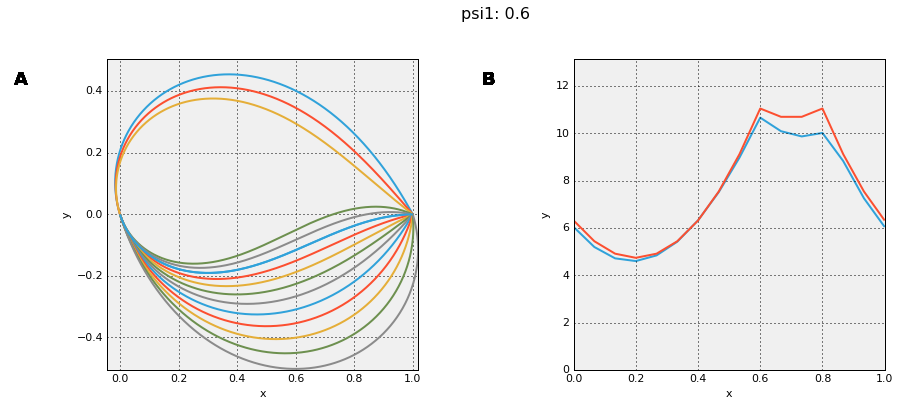
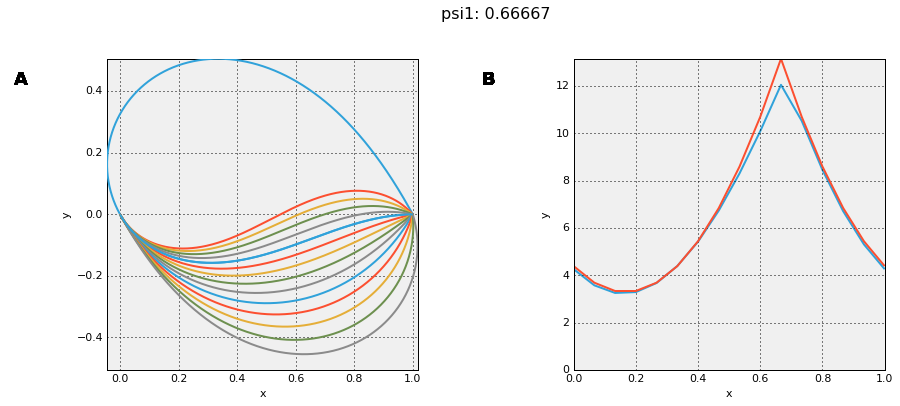
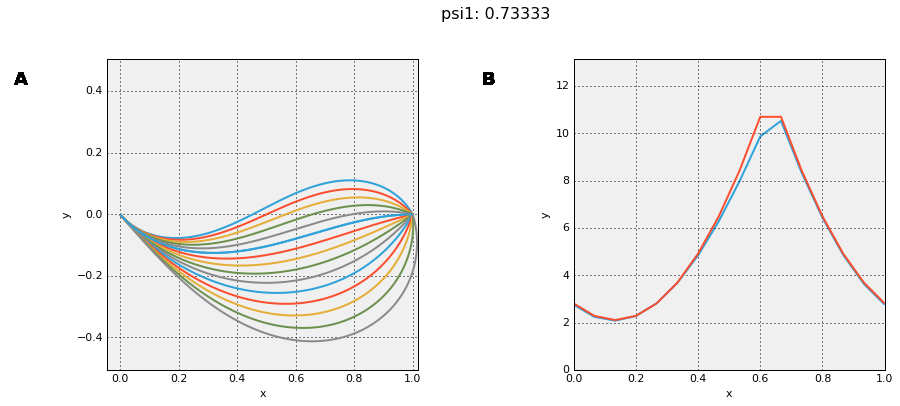
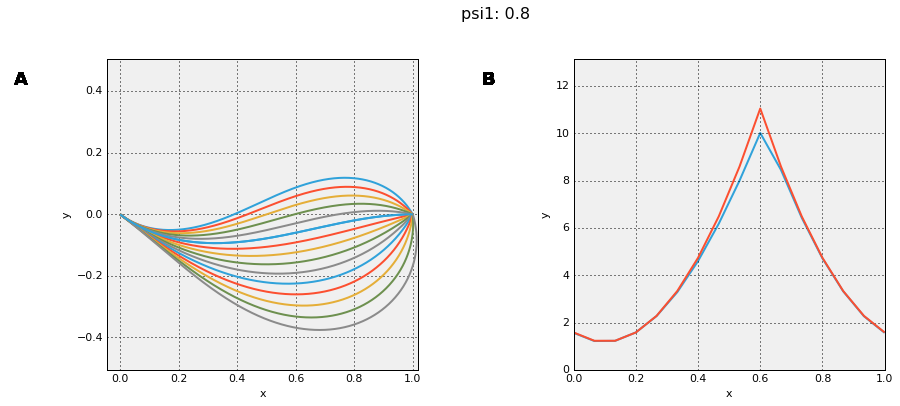
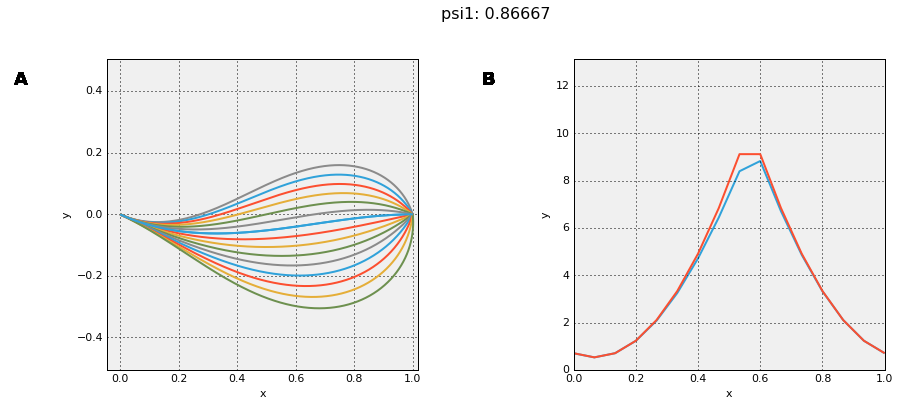
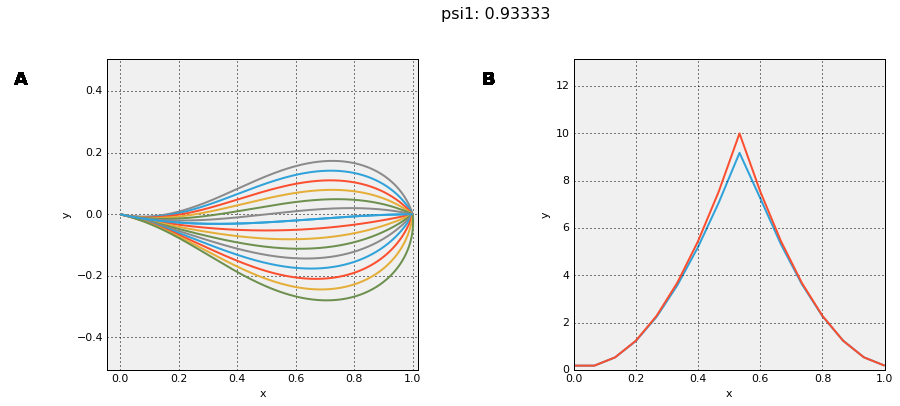
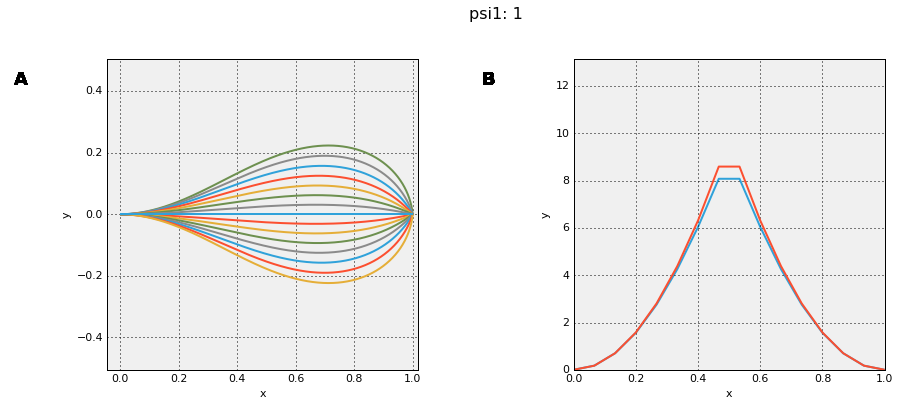

In [6]:
%%opts Curve norm{+axiswise}
curves+true_energies*derived_energies

Here it becomes especially apparant how the curves sometimes switch sides.

So there you have it! The basic elastica equations. Moving on, the sharon derivation will be used for the neural simulations, see the other ipython notebook.